In [1]:
import binance.spot # type: ignore
import fastai.tabular
import fastai.learner
import structs.candle2
import structs.candle_traits
import structs.normalization
import fetch.fetch
import torch
import pandas

In [2]:
class Args:
    pass

args = Args()
args.model = "data/JOINT.5m.100.model"
args.normalization = "std"
args.symbol = "ADAUSDT"
args.interval = "5m"
args.end_time = 0
args.predict_count = 100
args.batch_size = 100

In [3]:
# Prepare fields
target_field = "c"
traits = structs.candle_traits.CandleTraits.from_csv(target_field)
model_fields = traits.make_batch_fields(args.batch_size)

In [4]:
# Load a model
learner = fastai.learner.load_learner(fname=args.model)

In [5]:
# Prepare normalizer factory
normalizer_factory = structs.normalization.make_normalizer_factory(args.normalization, traits)

In [6]:
# Create binance connector
client = binance.spot.Spot()

# and fetcher
fetcher = fetch.fetch.Fetcher(client, traits)

In [7]:
# Fetch input and validation values

# Count to fetch
fetch_count = args.batch_size + args.predict_count

# Calculate end_time
end_time = args.end_time
if end_time <= 0:
    end_time = client.time()["serverTime"] + end_time

candles = fetcher.fetch_candles(args.symbol, args.interval, fetch_count, end_time)

In [8]:
%%capture
predictions = list(candles[0:args.batch_size])
for i in range(len(candles) - args.batch_size):
    input_candles = structs.candle2.make_copy(reversed(predictions[-args.batch_size:]))
    # Normalize
    normalizer = normalizer_factory.make_normalizer(input_candles)
    for candle in input_candles:
        normalizer.apply_inplace(candle)
    # Convert to pandas Series
    model_input = structs.candle2.make_pandas_series(input_candles, model_fields)
    # Predict
    _, pred, _ = learner.predict(model_input)
    predicted_candle = structs.candle2.Candle.from_data([pred], traits)
    normalizer.revert_inplace(predicted_candle)
    predictions.append(predicted_candle)

<AxesSubplot:>

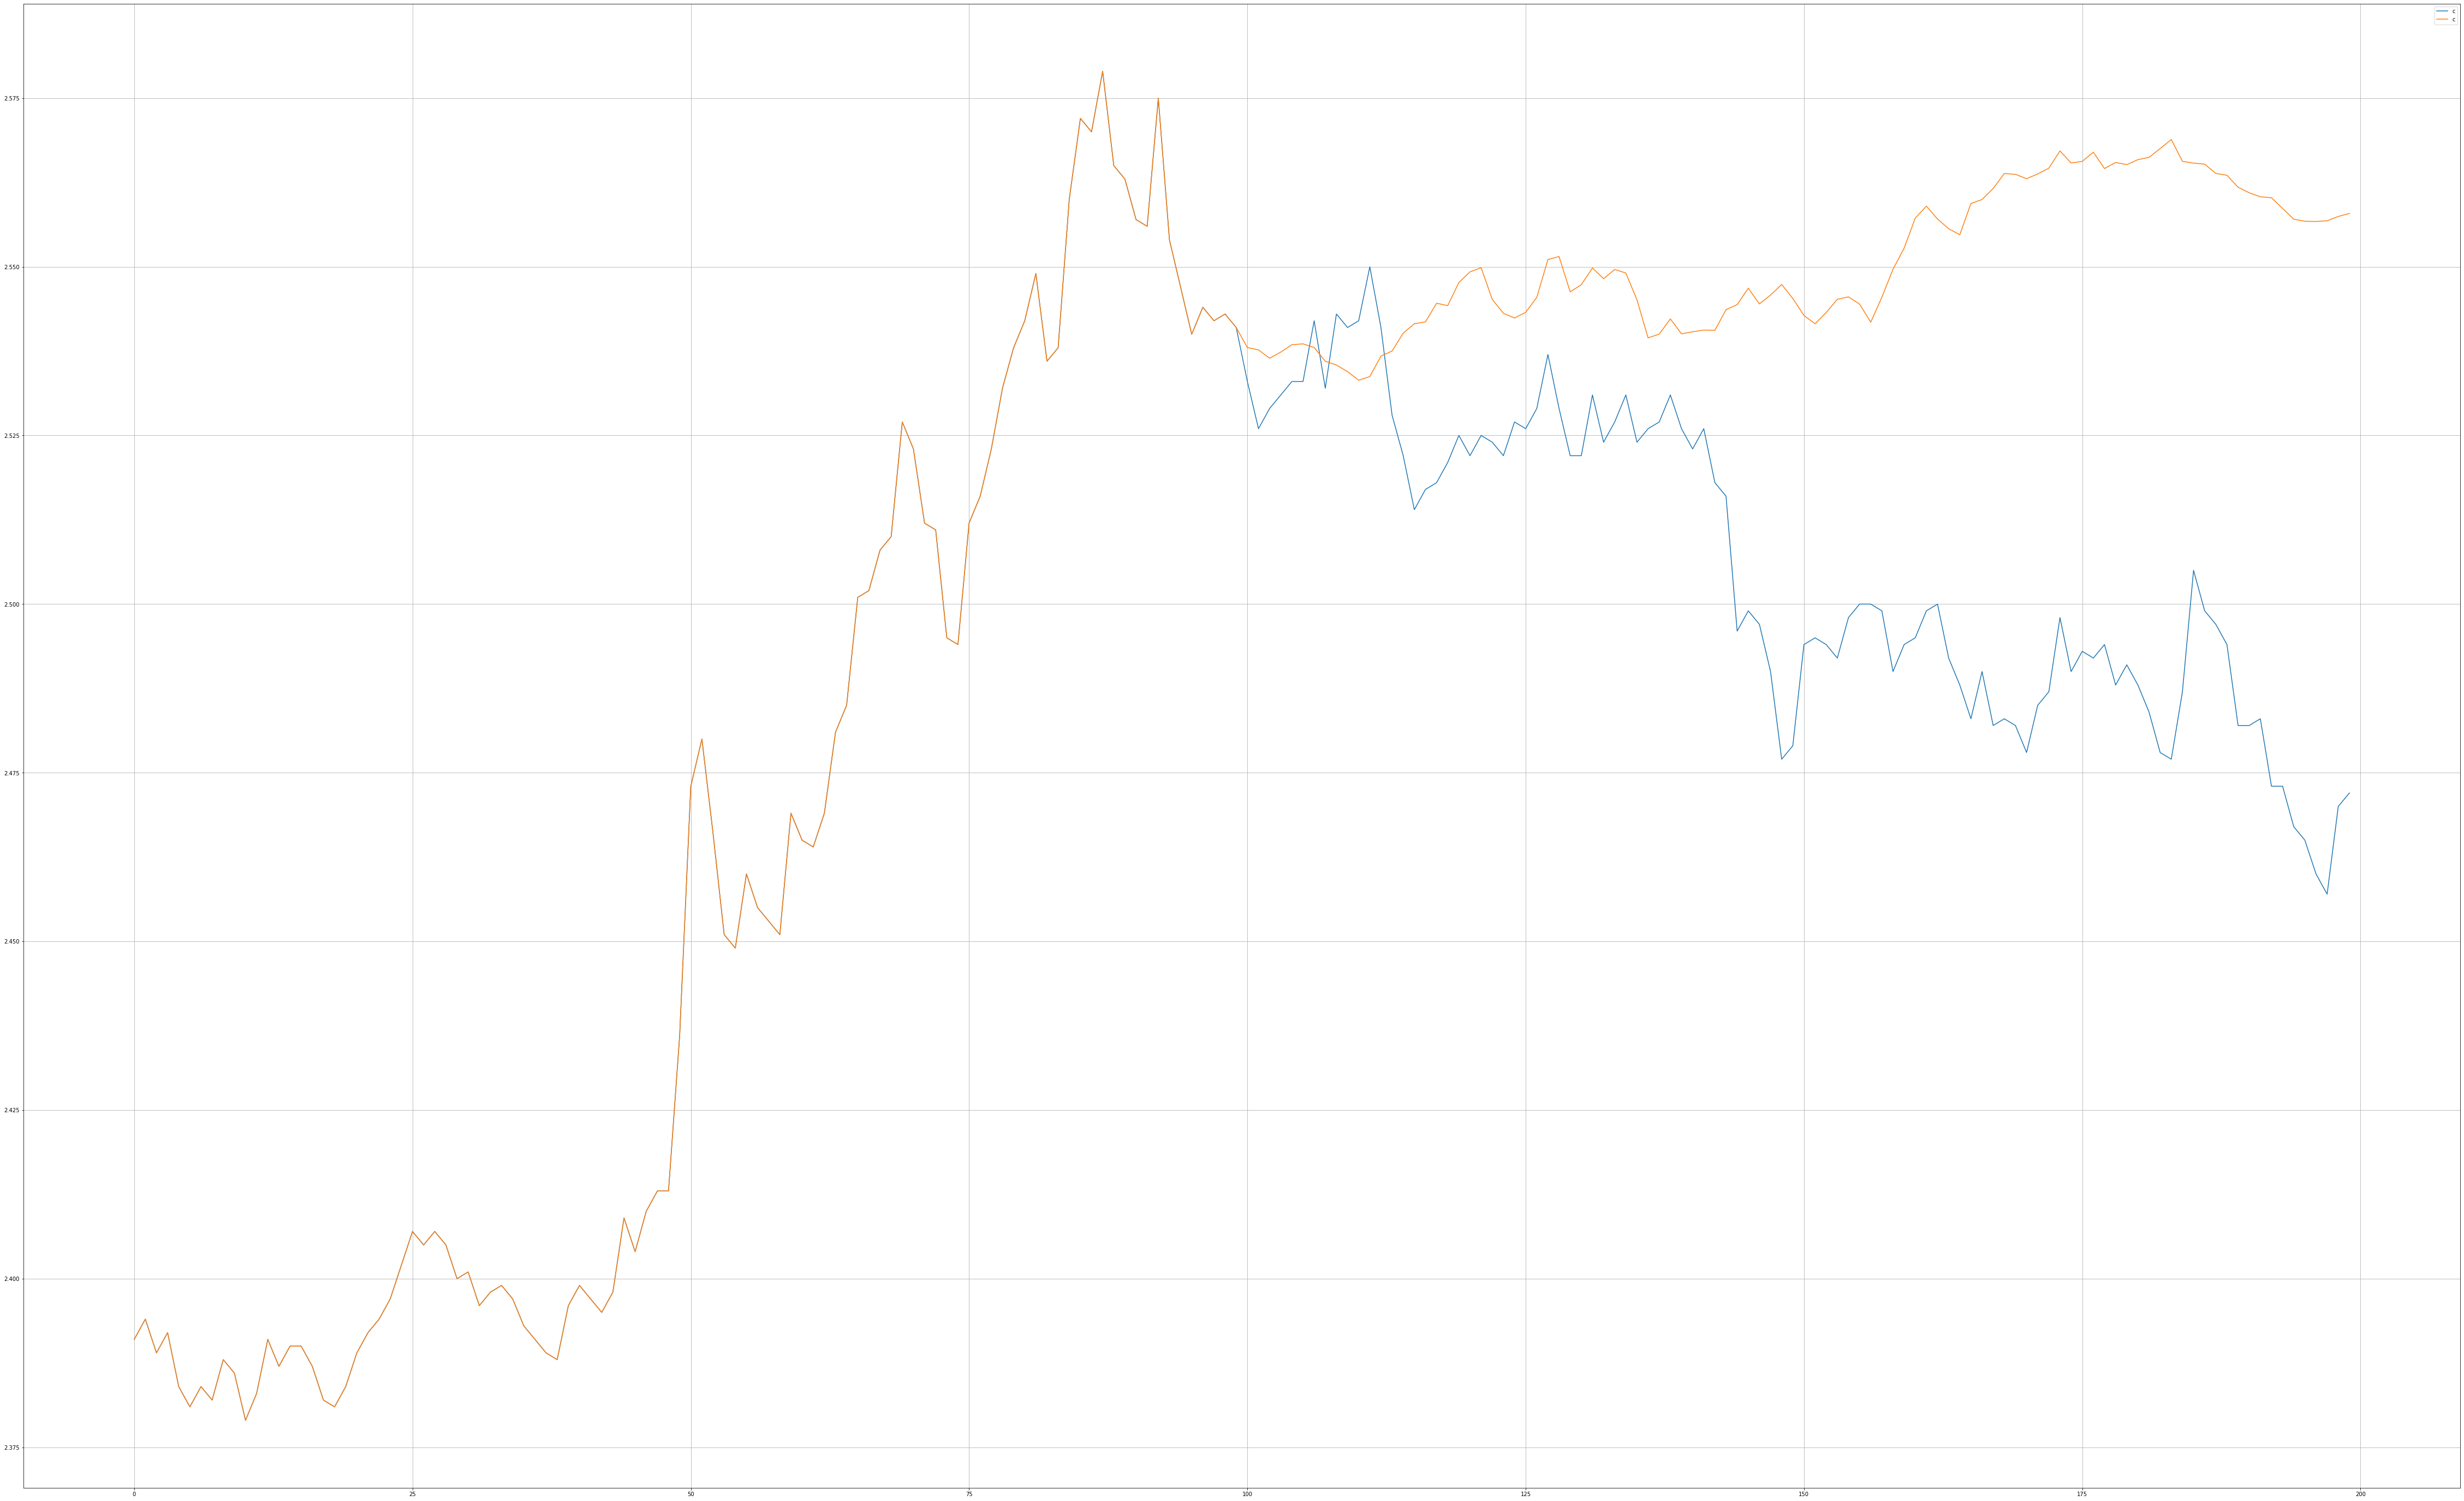

In [9]:
# Plot candles
data1 = structs.candle2.make_pandas_data_frame(candles, traits)
data2 = structs.candle2.make_pandas_data_frame(predictions, traits)
data = pandas.concat([data1, data2], axis=1)
data.plot(figsize=(80, 50), grid=True)